In [2]:
import math
import rich
import torch
import string
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
# import tensorflow_datasets as tfds

from tqdm import tqdm
from torch   import nn
from termcolor import colored

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# define the device to use
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rich.print(f"Device: [red]{DEVICE}")

Device: cuda

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/clean_data.csv')

# split the data
x = df['headline'].values
y = df['is_sarcastic'].values

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    # shuffle = True,
                                                    random_state = 2456)

print(colored("\nDIVIDED SUCCESFULLY...", "green"))


DIVIDED SUCCESFULLY...


In [6]:
unique, counts = np.unique(y_train, return_counts=True)
print("Training set distribution:")
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:")
print(dict(zip(unique, counts)))

Training set distribution:
{0: 10173, 1: 9359}

Test set distribution:
{0: 2559, 1: 2324}


In [7]:
# df = pd.read_csv('clean_data.csv')

# add new column 'headline_len': Text length of headline
df['headline_len'] = df['headline'].map(len)

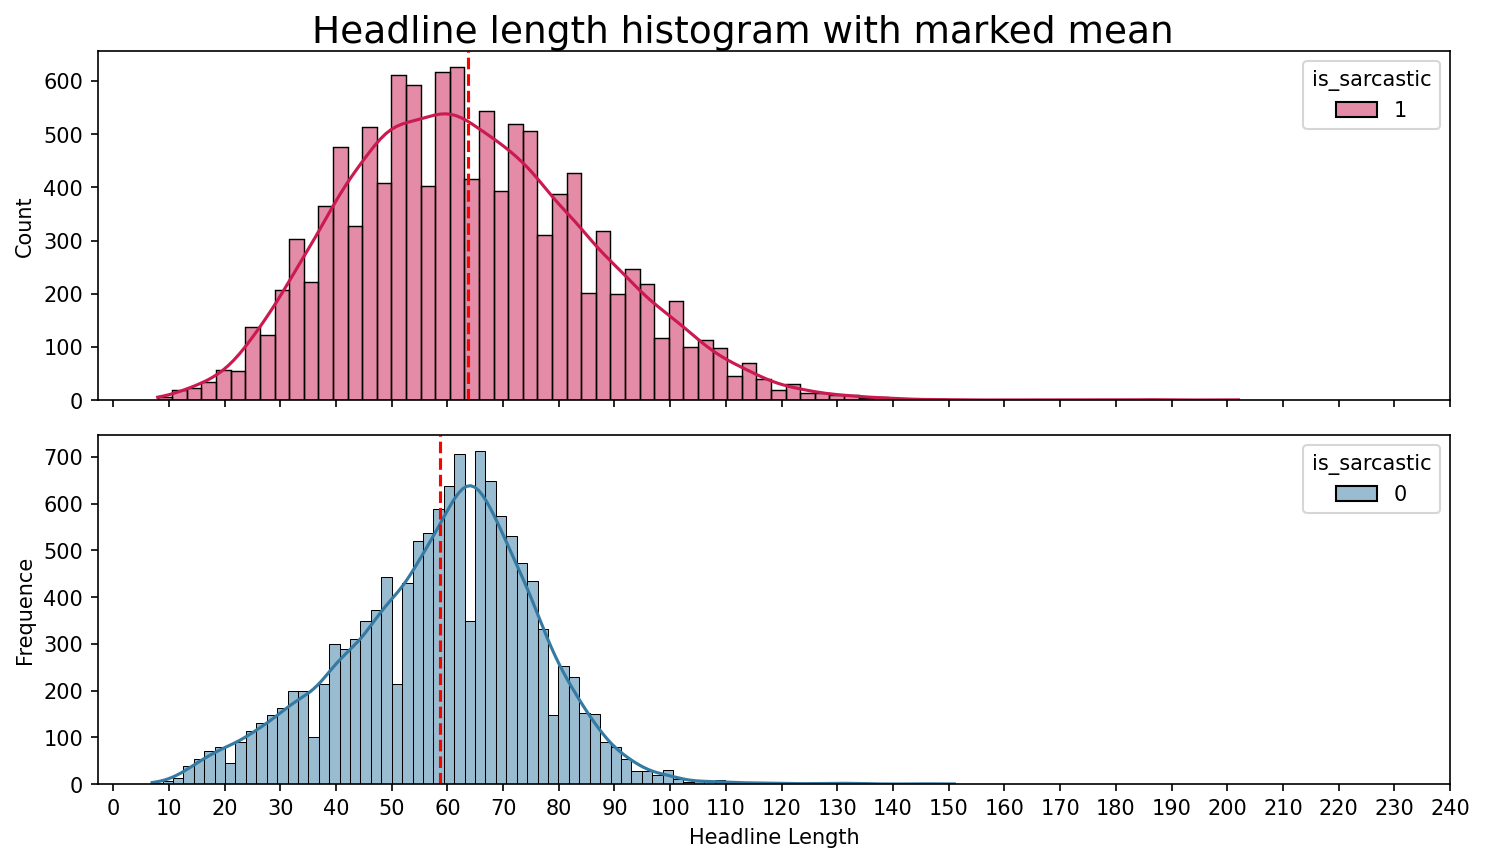

In [8]:
types = df['is_sarcastic'].unique()
cmap  = ['rocket_r', 'mako_r']

fig, axs = plt.subplots(2, 1, figsize=(10, 6), dpi=150,
                        sharex=True)
fig.subplots_adjust(hspace=.5)
for idx, x in enumerate(types):
    ax = plt.subplot(2, 1, idx + 1)
    subset = df[df['is_sarcastic'] == x]
    sns.histplot(data = subset[(subset['headline_len'] < 250)],
                 x = 'headline_len', hue='is_sarcastic',
                 kde = True, palette=cmap[idx])
    plt.xticks(np.arange(0, 250, 10))
    plt.axvline(subset[(subset['headline_len'] < 250)].headline_len.mean(),
                color='r', linestyle = '--')

plt.xlabel('Headline Length')
plt.ylabel('Frequence')
fig.suptitle('Headline length histogram with marked mean',
                x=.5, y=.95, fontsize=18)
plt.tight_layout()
plt.show()

In [9]:
# split the data
x = df['headline'].values
y = df['is_sarcastic'].values

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 11)

print(colored("\nDIVIDED SUCCESFULLY...", "green"))


DIVIDED SUCCESFULLY...


In [10]:
unique_words = set()
len_max = 0

for sent in tqdm(x_train):
    unique_words.update(sent)

    if(len_max<len(sent)):
        len_max = len(sent)

print(len(list(unique_words)))
print(len_max)

100%|██████████| 19532/19532 [00:00<00:00, 628944.35it/s]

38
911


In [11]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_test  = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=len_max)
x_test  = pad_sequences(x_test, maxlen=len_max)

print(x_train.shape, x_test.shape)

(19532, 911) (4883, 911)


In [12]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = "auto",
                               verbose = 1, monitor = "val_acc",
                               patience = 3)
callbacks = [early_stopping]

In [13]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    """
    Keras layer to compute an attention score for each input sequence.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Applying a linear layer (Wx + b)
        e = K.tanh(K.dot(x, self.W) + self.b)
        # Compute the weights
        a = K.softmax(e, axis=1)
        # Weighted sum of the input
        output = x * a
        # Sum over the time dimension to get the context vector
        return K.sum(output, axis=1)

    def get_config(self):
        return super(AttentionLayer, self).get_config()

from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(list(unique_words)), 100, input_length=len_max),
    tf.keras.layers.LSTM(64, return_sequences=True),  # LSTM layer with sequence output
    AttentionLayer(),  # Attention layer after LSTM
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=0.004),
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 911, 100)          3800      
                                                                 
 lstm (LSTM)                 (None, 911, 64)           42240     
                                                                 
 attention_layer (Attention  (None, 64)                975       
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 40)                2600      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                        

In [14]:
# # encoder_outputs is a tensor of shape (batch_size, max_len_text, latent_dim)
# # decoder_outputs is a tensor of shape (batch_size, max_len_summary, latent_dim)
# import tensorflow_addons as tfa
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(len(list(unique_words)), 100, input_length=len_max),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tfa.layers.Attention(),
#     tf.keras.layers.Dense(40, activation = 'relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(20, activation = 'relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10, activation = 'relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(5, activation = 'relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# model.compile(loss = "binary_crossentropy",
#               optimizer = Adam(learning_rate = 0.004),
#               metrics = ["accuracy"])
# model.summary()

In [15]:
history = model.fit(x_train, y_train,
                    epochs = 10, validation_data = (x_test, y_test),
                    batch_size = 16, verbose = 1,
                    callbacks = callbacks)

Epoch 1/10
1220/1221 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5185

1221/1221 [==============================] - 52s 33ms/step - loss: 0.6930 - accuracy: 0.5184 - val_loss: 0.6917 - val_accuracy: 0.5273
Epoch 2/10
1221/1221 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5190

1221/1221 [==============================] - 40s 32ms/step - loss: 0.6925 - accuracy: 0.5190 - val_loss: 0.6917 - val_accuracy: 0.5273
Epoch 3/10
1220/1221 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5200

1221/1221 [==============================] - 36s 30ms/step - loss: 0.6925 - accuracy: 0.5200 - val_loss: 0.6917 - val_accuracy: 0.5273
Epoch 4/10
1219/1221 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5199

1221/1221 [==============================] - 38s 31ms/step - loss: 0.6925 - accuracy: 0.5200 - val_loss: 0.6919 - val_accuracy: 0.5273
Epoch 5/10
1219/1221 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5198

1221/1221 [==============================] - 37s 30ms/step - loss: 0.6925 - accuracy: 0.5200 - val_loss: 0.6917 - val_accuracy: 0.5273
Epoch 6/10
1220/1221 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5199

1221/1221 [==============================] - 36s 29ms/step - loss: 0.6925 - accuracy: 0.5200 - val_loss: 0.6917 - val_accuracy: 0.5273
Epoch 7/10
1220/1221 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5185

1221/1221 [==============================] - 38s 31ms/step - loss: 0.6925 - accuracy: 0.5186 - val_loss: 0.6921 - val_accuracy: 0.5273
Epoch 8/10
1220/1221 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5201

1221/1221 [==============================] - 37s 31ms/step - loss: 0.6926 - accuracy: 0.5200 - val_loss: 0.6919 - val_accuracy: 0.5273
Epoch 9/10
1220/1221 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5199

1221/1221 [==============================] - 38s 31ms/step - loss: 0.6925 - accuracy: 0.5200 - val_loss: 0.6917 - val_accuracy: 0.5273
Epoch 10/10
1221/1221 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5192

1221/1221 [==============================] - 36s 29ms/step - loss: 0.6924 - accuracy: 0.5192 - val_loss: 0.6917 - val_accuracy: 0.5273


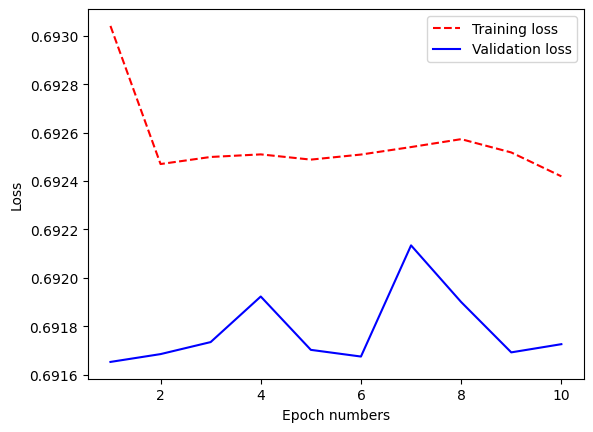

In [16]:
epoch_num = range(1, len(history.history["loss"]) + 1)
plt.plot(epoch_num, history.history["loss"], "r--")
plt.plot(epoch_num, history.history["val_loss"], "b-")
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Epoch numbers")
plt.ylabel("Loss")
plt.savefig('GMP_loss_plot.png', dpi=300)
plt.show()

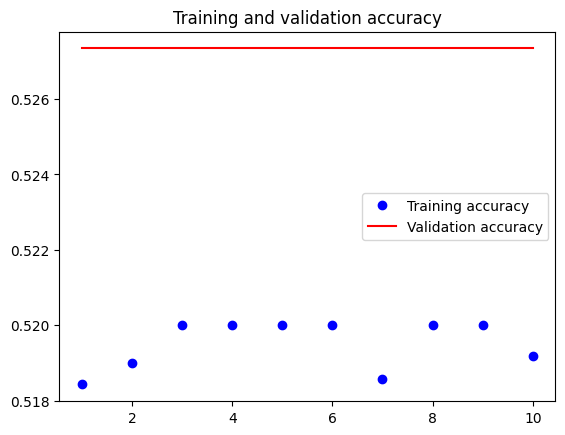

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('GMP_acc_plot.png', dpi=300)
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from attention_layer import AttentionLayer  # Import your AttentionLayer implementation

# Example sentence
input_sentence = "icpnic Napalm Rights advocate dead at 100"

# Tokenize input sentence using a simple split (replace with your tokenizer)
tokens = input_sentence.split()

# Example token_to_index mapping (replace this with your actual mapping)
token_to_index = {word: idx for idx, word in enumerate(tokens)}

# Convert tokens to indices using the token_to_index mapping
token_indices = [token_to_index[token] for token in tokens]

# Expand dimensions to create a batch dimension (1 in this case) and convert to numpy array
input_sequence = np.expand_dims(np.array(token_indices), axis=0)

# Get attention weights using your model
attention_weights = model.layers[1](model.layers[0](input_sequence))

# Visualize attention weights as a bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x=tokens, y=attention_weights[0].numpy().flatten(), palette="viridis")
plt.title('Attention Weights for Each Word in the Sentence')
plt.xlabel('Words')
plt.ylabel('Attention Weights')
plt.show()


KeyError: ignored

<Figure size 1000x400 with 0 Axes>